# 앙상블 학습과 랜덤 포레스트

- 예측기 == 앙상블

- 대중의 지혜 : 복잡한 질문에 대한 무작위로 선택된 수천 명의 사람의 대답이 전문가의 답보다 낫다
- 앙상블 학습 ensemble learning : 일련의 예측기의 예측 성능이 가장 좋은 모델 하나의 예측 성능보다 좋다. 

- 앙상블 학습 알고리즘 == 앙상블 방법 ensemble method

앙상블 방법 예시) 
1. train dataset에서 무작위로 중복없는 서브셋을 만든다. 
2. 서브셋으로 일련의 결정 트리 분류기를 훈련한다.
3. 예측하려면 모든 개별 트리의 예측을 구한다.
4. 가장 많은 선택을 받은 클래스를 예측으로 삼는다.
- 결정 트리의 앙상블 == 랜덤 포레스트 

- 앙상블 방법 종류 : 배깅, 부스팅, 스태킹

다양한 분류기 만들기
1. 다른 훈련 알고리즘 사용하기
2. 같은 훈련 알고리즘을 사용하기 & 다른 데이터셋 사용하기(훈련 세트의 서브셋을 무작위로 구성)

## 1. 투표 기반 분류기

1) 매우 간단한 방법
- 다양한 예측기의 예측을 모아서 가장 많이 선택된 클래스로 예측한다.
- 다수결 투표로 정해지는 분류기 = 직접 투표 hard voting 분류기
- 각기 다른 알고리즘으로 학습하는게 좋음
- 원리 : 횟수를 거듭할수록 확률은 계속 달라지고 특정 예측값인 것의 확률이 계속 올라갈 수 있기 때문
- 조건 : 모든 분류기가 완전히 독립적, 오차에 상관관계가 없어야 함
- 이 방법으로 하기 힘든점 : 보통 같은 데이터로 훈련하고, 같은 종류의 오차를 만들기 쉽다


In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


VotingClassifier 의 성능이 가장 좋은 것을 확인할 수 있다.

- 이처럼 predict_proba() 메서드를 가지고있어 클래스의 확률을 구할 수 있다면 앙상블 학습이 가능하다.
- 개별 분류기의 예측을 평균내고 확률이 가장 높은 클래스로 예측한다. = 간접 투표 soft voting
- `VotingClassifier(voting="soft")`
- 확률을 제공하지 않는 경우_ SVC와 같은 경우 `probaility=True` 로 설정하여 확률을 제공받음

## 2. 배깅과 페이스팅
dataset을 sampling하는 방식

- 배깅 bagging : training dataset에서 중복 허용한 sampling 방식
- 페이스팅 pasting : training dataset에서 중복 허용하지않은 sampling 방식
So, 배깅과 페이스팅에서 하나의 training dataset으로 분류기에 쓸 수 있다. 

여기서 sampling 하는 것을 부트스트랩이라고 한다.

- 부트스래핑 -> 각 예측키 서브셋 다양성 증가 -> (배깅 편향성 > 페이스팅 편향성) 
    + (다양성 추가 = 예측기 상관관계 감소 = 앙상블 분산 감소)

수집함수로 보통 {분류 : 통계적 최빈값}, {회귀 : 평균값} 를 지정한다.

개별 예측키는 편향과 분산값이 크지만, 수집함수를 통과하면 편향과 분산값이 감소한다. 

할 수 있다면 배깅과 페이스팅 교차검증 실행하여 더 나은 설정 선택

예측기는 모두 다른 CPU 코어 혹은 서버에 병렬로 학습이 가능하다.
예측도 병렬 수행이 가능하다.

### 2.1 사이킷런의 배깅과 페이스팅
사이킷런의 BaggingClassifier API 사용가능

예) Decision Tree 분류기 500개 앙상블을 훈련시켜보자. \
BaggingClassifier에 DecisionTreeClassifier 넣어 만들기 
1. training dataset 중복 허용, 무작위로 100개 샘플링
2. n_jobs 로 training, predict시 사용할 CPU 코어 갯수 지정 (-1은 모든 코어 사용)

In [2]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

- BaggingClassifier로 만든 모델의 정확도

In [3]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


- Decision Tree로만 만든 모델의 정확도 \
배깅 방법으로 샘플링하여 앙상블 학습한 모델의 정확도가 더 높다.

In [4]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [7]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


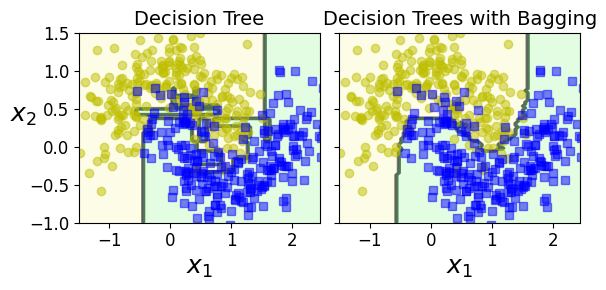

In [13]:
fig, axes = plt.subplots(ncols=2, figsize=(6,3), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

- 더 적은 편향과 더 적은 분산

### 2.2 oob평가
앙상블 평가하는 방법 \
배깅 샘플링 방법을 선택 -> 중복허용이 되므로 전체 데이터 중 선택되지 않은 데이터 발생 -> 선택되지 않은 샘플 비율 = oob (out-of-bag) 샘플

training한 앙상블 모델에 학습시 사용되지 않은 데이터셋을 사용한다는 점에서 oob 샘플을 사용해 예측값을 뽑아내 평가할 수 있겠다. \
BaggingClassifier에서 oob_score=True로 설정, oob_score_ 변수를 통해 확인가능.

BaggingClassifier에 DecisionTreeClassifier 넣어 만들기 

In [14]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

oob_decision_function_ 변수 에서 결정 함수(각 훈련 샘플의 클래스 확률 return)의 값 확인

In [15]:
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

## 3. 랜덤 패치와 랜덤 서브스페이스

특성 샘플링하기 \
특성 샘플링 조절 매개변수 : max_features, bootstrap_features

랜덤 패치 방식 random patches method : training 특성 & 샘플 모두 샘플링   \
랜덤 서브스페이스 방식 random subspaces method : training 특성만 샘플링 (bootstrap=False, max_samples=1.0, bootstrap_features=True, max_features=(1.0보다 작게))

## 4. 랜덤 포레스트
Usually 배깅/페이스팅 방법을 적용한 Decision Tree ensemble

RandomForestClassifier
- max_samples로 훈련 세트 크기 지정
- BaggingClassifier의 매개변수 가지고 있음 (Decision Tree Classifier의 매개변수와 앙상블 자체를 제어한다)
- 전체가 아닌 무작위로 선택한 특성 후보 중 최적의 특성을 찾는다. 
- 무작위성이 주입돼서 트리가 더 다양해짐. 다양해진다=='분산' 감소 (bootstraping 참고, (다양성 추가 = 예측기 상관관계 감소 = 앙상블 분산 감소))

예) 500개 트리로 이루어진 랜덤 포레스트 분류기를 여러 CPU코어에서 훈련시키기 

RandomForestClassifier 사용 - Decision Tree에 최적화 (앞서서는 BaggingClassifier에 DecisionTreeClassifier 넣어 만듦) 



In [16]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [17]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

RandomForestClassifier 분류기와 BaggingClassifier - DecisionTreeClassifier 분류기 비교 \
결과값이 아주 같다.

In [18]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # very similar predictions

1.0

### 4.1 엑스트라 트리

최적의 임곗값 searching - 가장 시간이 많이 소요되는 작업 -> 임곗값 대신 후보 특성 사용
random forest - 트리 만들기 (후보 특성을 사용해 무작위로 특성의 서브셋을 만들어 분할, 그 중 최상의 분할 선택)

익스트림 랜덤 트리 extremely randomized trees 앙상블 : 극단적 무작위 트리 랜덤 포레스트
편향 증가, 분산 감소

### 4.2 특성 중요도

랜덤 포레스트 이용한 특성의 상대적 중요도 측정 가능 - 중요한 특성을 빠르게 가려낼 수 있다.


scikit-learn 에서 제공하는 것 
- 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 계산, 가중치(연관된 훈련 샘플 수만큼 있다) 평균
- 특성마다 자동으로 점수 계산
- 중요도 전체 합이 1이 되도록 결과값 정규화
- feature_importances_ 변수에서 확인 가능


In [19]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [20]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

## 5. 부스팅

- 앙상블 방법 중 하나
- 약한 학습기를 여러개 연결하여 강한 학습기를 만든다
- 앞의 모델을 보완해가면서 학습한다
- 에이다부스트 AdaBoost, 그레이디언트 부스팅 gradient boosting

### 5.1 에이다부스트 AdaBoost
